# AM207 Final Paper - Decomposition of Uncertainty in Bayesian Deep Learning for Efficient and Risk-Sensitive Learning

## Team Members
* Owen Callen
* Gabriel Pestre
* Hayden Sansum
* Nikhil Vanderklaauw

## Selected Paper:

- Depeweg et al (2018). Decomposition of Uncertainty in Bayesian Deep Learning for Efficient Risk-sensitive learning. arXiv:1710.07283v4.
Available at: https://arxiv.org/pdf/1710.07283.pdf


## Overview

This is the final report for our project. All of the source code can be found in in our [Github repo](https://github.com/2020fa-207-final-project/decomposition-of-uncertainty) (see readme for details on content).

This report has the following sections:
* **[Problem Statement](#Problem-Statement)**
* **[Context](#Context):** This section contains a general overview of important concepts to understand before reading our paper.
    * [Latent Variables: a simple motivational example](#Latent-Variable-Models:-a-simple-motivational-example)
    * [Noise and Uncertainty](#Noise-and-Uncertainty)
    * [Reinforcement Learning](#Reinforcement-Learning)
* **[Existing Work](#Existing-Work):** This section provides context for the other work being done around this paper.
* **[Contribution](#Contribution):** This section explains how our work extend the existing work from the original paper.
* **[Bayesian Modeling Context](#Bayesian-Modeling-Context):** This section provides additional context about bayesian neural networks, Including those with latent variables.
* **[Technical Implementation](#Technical-Implementation):** This section covers a lot of the design choises we made as we were modeling.
    * [BBN+LV](#BNN+LV)
    * [Entropy Decomposition](#Entropy-Decomposition)
    * [BBVI](#BBVI)
    * [BB-alpha](#BB-alpha)
    * [HMC & NUTS](#HMC-&-NUTS)
* **[Experiments](#Experiments):** We consider three primary experiments in this paper. 
    * [Heteroscedastic Noise](#Heteroscedastic-Noise)
    * [Bimodal Noise](#Bimodal-Noise)
    * [Reinforcement Learning Wet Chicken](#Reinforcement-Learning-Wet-Chicken)
* **[Comparing Results](#Comparing-Results):** This section compares our results to the results from the original paper.
* **[Evaluation](#Evaluation)** Here we evaluate the claims made by the authors of the original paper.
* **[Future Work and Improvements](#Future-Work-and-Improvements)** Here we consider potential extensions that could be pursued in the future.
* **[Broader Impact](#Broader-Impact)** In the section we broadly consider the usage of BNN+LV.
* **[References](#References)**



## Problem Statement


In Machine Learning, we train a model on a set of inputs with known output values, 
with the goal of learning a function that can perform this prediction task on new inputs. 
In most practical applications, there is always some degree of uncertainty in the relathionship 
between inputs and outputs, either because of missing information or randomness in the underlying process. 
The authors of this paper \[1\] propose a method of utilizing the flexibility of a Bayesian Neural Network 
with Latent Variables to allow for the decomposition of Aleatoric and Epistemic Uncertainty.

The ML field has proposed a number of ways to gain insight into the overall uncertainty, 
such as frequentist bootstrapping (running multiple trials) or implementing a Bayesian 
modeling approach to incorporate a distribution over models. 
However, both these approaches only provide the overall magnitude of the uncertainty and 
do not allow for further interrogation of where those uncertainties might be coming from. 
Without knowing how much of the variation is due to inherent randomness (aleatoric) 
or due to the lack of training data in specific parts of the domain (epistemic) there 
is no way to know precisely how much to trust the model or how to improve it. 
For instance would it be useful to collect more data on a certain type of input? 
Would it be useful to defer the prediction to an expert? 
In reinforcement learning this could be framed as, where does my agent need to explore 
more to maximize how much it learns about the environment? 
Being able to decompose uncertainty into these two core components, epistemic and aleatoric 
(whilst still using a complex and flexible model such as a neural network) 
enables practioners of data science and statistics to tackle these problems. 


## Context


Before diving into our methodology we think it's important to clearly define the number of foundational ideas 
that we used throughout this paper.  The following subsections walk through a high level summary of our 
understanding of these key concepts.


### Latent Variable Models: a simple motivational example



Latent variables are simply variables that we do not include explicity as predictors in our model,
either because we did not collect in our data collection process or because they are unobservable.
If we know there are important variables that were not gathered that should have an impact on our predictions,
it is unwise to simply model using the data we have. Rather we should instead find a way of accounting for these 
hidden variables and include this accounting in our model. Let us consider a simple example.

Imagine we are trying to model baby weights in a particular town. We have gathered data on the number of 
weeks in a pregnancy and the weights of the babies. However, we believe there are two populations in the town, 
one of football players who tend to have extremely large children, and one of the rest of the general population. 
We could choose to ignore this information and use the following very naive model:
$$
\text{weight} \sim f(\text{weeks}) + \text{noise}
$$
This would be a bad idea because we know intuitively that there should be two different peaks in the outputs of our model, 
one for the football players and one for everyone else, yet our model without the latent variable would be unimodal.
We would predict lots of large babies, rather than a few enormous babies, and many normal sized babies.
The problem with this model is that even though the average predictions are relatively good, 
the posterior distribution for such a model would look completely different than 
if we modeled either of the sub-populations separately. 
The solution to this is to assume that there is a latent variable that indicates belong to one or the other 
of the sub-population and to simulate this variable as we are training our model. 

In the context of this paper we frequently model 
$$
Y \sim f(X, Y) + \text{noise}
$$
where $Y$ is a known quantity or set of quantities we are trying to predict, $X$ is an known set of predictors, 
and $Z$ is an unknown predictor that we are stimulating as a random noise. 
The function $f$ that we use is almost always some flavor of Bayesian neural network (BNN).
We make this choice when we have reason to believe there is a complex nonlinear relationship 
between the protectors and response variables. 
Neural networks are good universal function approximators, meaning we can apply them even 
when we don't know the exact functional form of the model we are trying to learn.


### Noise and Uncertainty



Many common statistical models, including ordinal least squares (OLS) linear regression,
require us to assume and verify that the noise in our observations is homoscedastic, 
meaning that the errors we expect to see for any given observation are independent from
the particular $X$ values used to create that prediction.
So whether $x = 2$ or $x = 7$, we assume the error comes from the exact same distribution.
In particular, if we've assumed noise is distributed normally around a mean of zero, 
the homoscedastic assumption requires that the variance of the noise distribution must be 
the same for any $X$.
In a simple linear regression we might express this by saying 
$$ y = \beta_0 + \beta_1 * x + \text{noise} $$
where $\text{noise} ~ N(0, \sigma^2)$. 
In this paper, we frequently consider situations where this assumption is violated, meaning, the noise term 
is drawn from something that is not a normal distribution (potentially a bimodal distribution), or the noise 
heteroscedastic i.e. it depends on x (noise ~ $N(0, x\sigma^2)$). 

Another key aspect of this paper is to consider, and distinguish between, the root causes of  uncertainty. 
One major cause of uncertainty is a lack of data. This kind of uncertainty Is called epistemic uncertainty, 
and can be solved by simply gathering more data. The other source of uncertainty is noise, and is referred 
to as aleatoric uncertainty. There may not be an effective way of predicting a response variable from a given 
set of predictor variables, or if the prediction can be made it is only fuzzy correlation at best. This lack 
of a deterministic relationship between two quantities is likely the result of noise or randomness.

An alternative way of understanding the two types of uncertainty is that we have uncertainty about what the model 
should actually be (in the linear case what is the slope, and what is the intercept?), and uncertainty resulting 
from pure randomness that cannot be reduced. Being able to determine the source of uncertainty is incredibly 
important, because it allows us to determine the best fix. If the problem is simply a lack of data we can go out 
and get more data. However, if the problem is a noisy relationship, we may need to find different or better 
predictors in order to improve the model. It may also be the case that we simply cannot improve the model, 
because some outcomes are the result of a process that is, at least in part, truly random.


### Reinforcement Learning



Reinforcement learning (RL) is a paradigm of machine learning where we try to learn the optimal behavior of an agent in a system.
We assume the system has unknown but coherent dynamics that the agent can learn to navigate: 
the system has a number of states, and in each state the agent takes an action that may incur a cost or produces a reward 
and move the system to a new state. The transition and reward functions may depend on some combination of the current state and action, 
the history of previous states and actions, and an element of chance.

Unlike supervised learning, where we try to learn the parameters of a model to optimize a well-defined objective function 
(such as accuracy or mean square error), in the RL paradigm the goal is to learn an optimal policy, which tells the agent 
which action to take in each state, to maximize rewards. The reward structure is initially unknown, and the agent
learns through continuous feedback from its environment. 
There are two catergories of approaches, model-based RL and model-free RL, for learning an optimal policy.

- In the model-free approach the agent starts with an arbitrary ploicy and iteratively tries to improve it 
without explicity learning the dynamics of the system (i.e. it does not need to understand the transition 
probabilities from state to state, or which states/actions produce rewards, as long as its policy provides 
an effective protocol for accruing rewards in this environment. 

- In the model-based learning approach, we approach the problem in two stages: we first try to learn to predict 
the dynamics of the system (e.g. if we take a particular action from a particular state, what reward to we expect
to earn and what new state do we expect to end up in?); then use this model to simulate outcomes as we try to 
iteratively improve the policy. If the states are fully known to the agent, then we can be represented 
the environment a standard Markov Decision Process (MDP), whereas if states are hidden (partially observed) 
from the agent then we can model it as a Partially Observable Markov Decision Process (POMDP). 

This paper focuses on model based-learning: we use observations collected from an environment to learn its 
transition function, and then decompose the uncertainties to understand how much of the unpredictability is 
due to the environments inherent stochasticity and how much is due to our model's limitations or lack of data.
(The second stage of model-based learning, namely using the learned model to conduct policy improvement, 
also presents interesting use cases for uncertainty decomposition but is beyond the scope of our project.)

The applications of RL are widespread and can be used to tackle large scale social good problems which would be traditionally
very challenging to solve. Xu at al. \[14\] utilize a combination of supervised and reinforcement learning to learn about the 
behaviour of poachers in Cambodia and then plan optimal patrol routes for park rangers to thwart their actions. Uncertainty
in this context is vital due to adversarial nature of the problem. 


## Existing Work


Decomposition of Uncertainty in Bayesian Deep Learning, builds upon the foundations of an earlier paper by the same authors (2017) in which they explore the usefulness
of adding a random gaussian noise input in order to aid with policy search in dynamic systems. \[2\] While this architecture is not explicitly referred to as a 
BNN+LV in this paper, it is clear that this is the original proposal of such a system. The major reason cited by the authors for adding the latent variable on the input
is due to the otherwise limited nature of having the stochasticity of the system represented only by a single, additive Gaussian output noise. This prior paper also
utilizes the Wet Chicken Problem (a reinforcement learning set up, described below in Experiments) as a demonstration of the effectiveness of this new BNN+LV architecture.

In an extention to the paper under review here, the same authors also propose utilizing the decomposition of uncertainty technique to perform a sensitivity analysis 
on the aleatoric and epistemic components separately. \[4\] This natural follow up to the original two papers as it utilizes both the decomposition of uncertainty and also
the ability of the BNN+LV architecture to fix the weights and sample over multple latent variables, or alternatively fix the latent inputs and vary the weights in order
to test the different components of the uncertainty.

In addition to follow up work by the same authors, Yacoby, Pan and Doshi-Velez (2019) \[3\] also investigated the BNN+LV architecture and found issues with 
unidentifiability. They posit that the variations present in the data can be equally well learned by either the weights or the latent input variable, hence rendering
the model difficult to train and easy to overfit. This problem is specific to BNN+LVs as the latent variable, which forms part of the posterior, is not utilized when
making new predictions and is instead resampled from a standard gaussian distribution, hence the weight values (sampled from the original posterior) may no longer
be correctly aligned. We consider this to be similar to a case of fitting linear regression with two correlated features, the coefficients on these two features can 
vary by high amounts and still give the same output predictions. Removing one of the two variables from the linear model however, whilst retaining the other at it's
fixed parameter value from the original training would clearly be problematic for predictions. The authors propose a solution based around a new method of approximate
inference which relies on first training the weights and latent noise independently before training them together and penalizing their deviations from the original
modeling assumptions. While we do no go so far as to implement this new method of approximation, we do take inpiration from the idea of first fixing the noise to get
an initial set of trained weights before training both components together, as described in more details in Experiments and also in the fit method of our BNN+LV class.

A core technical development which enabled the probabilistic modeling of neural networks in a Bayesian context was the Bayes by Backprop concept introduced by Blundell
et al. \[5\] Originally proposed as an alternative method of regularization in feed forward networks to traditional techniques such as drop out, Bayes by Backprop 
proposes using an approximation to the true posterior of the neural network (an expected lower bound) and then leveraging a divergence metric to minimize the difference
between this approximation and the true posterior. This insight opened up the possibly of efficient sampling from a neural network posterior without needing to rely on
complex and slow sampling methods (such as HMC) whose convergence is not guaranteed due to the complexity of the true posterior. Further details on how "Bayes by Backprop"
enables this probabilistic training of weights can be found in our Technical Content section under "BBVI".

This paper also leans heavily upon existing literature demonstrating the use of the KNN algorithm as a method of approximating the entropy of a set of data points.
Original described by Kozachenko and Leonenko back in 1987 \[7\], before being expanded upon by Singh et al. in 2003 \[8\], this approach enables a computationally efficient
metric for estimating the amount of entropy in a system, an important component of the decomposition seeing as it needs to be be calculated at each datapoint and across
multiple different models. 

Interestingly, in our search for existing literature on the use of Entropy in decomposing uncertainties into epistemic and aleatoric components, 
a number of engineering papers had already leveraged the approach. Robertson et al's paper on Wind Turbine uncertainty \[9\] separated variables into modeling variables
and natural parameters (with the modeling variables capturing the epistemic and natural parameters capturing the aleatoric uncertainty). In a way this 
is a parallel to how Depeweg et al. splits out epistemic as uncertainty over modeling weights and aleatoric as the remaining uncertainty inherent in the data. 
Gong et al's research into hydrolic modeling \[10\] lays out this concept in a more general manner where the aleatoric uncertainty is what remains after 
attributing some component of the total uncertainty to the mutual information between the data and the output (epistemic).

In a 2017 paper by Kendall and Gal \[6\], the authors highlight how the decomposition approach proposed here can be applied to supervised learning tasks 
utilizing a standard BNN, excluding the latent variables. The authors of this paper also utilize the concepts of entropy and marginalizing over the weights
of the models sampled from the posterior. Their specific use case was to improve image classification performance in cases with high amounts of heteroscedastic
noise and conclude that their BNN implementation is successful in this regard. They do not however test this on bimodal noises cases where we suspect
the latent variable representation, proposed in the paper we are reviewing, will add significant value.


## Contribution


The contribution of this paper is threefold and centers on the uniqueness of utilizing a BNN+LV with uncertainty decompositions:

1. The specific methods (described below in our technical section) of decomposing the predictive uncertainty 
of a BNN+LV into epistemic and aleatoric uncertainties by using entropy and variance. 
The algorithm used to calculate the entropy of a set of data has been around since the original Kozachenko 
paper in 1987 \[8\] and the overall approach, as mentioned above, of using entropy as a method to decompose 
uncertainty was proposed and utilized in engineering at least back as far as 2013. 
It is in this context however, applying the decomposition methods to a BNN+LV and utilizing that to be able to 
separate the aleatoric and epistemic compnents of a neural network that are a unique contribution.

2. The authors demonstrate the ability of the BNN+LV, when applied with the decomposition of uncertainty approach, 
to separate out epistemic and aleatoric
uncertainties from even very complex functions such as those with bimodal or heteroscedastic noise. This innovation 
allows for practictioners to identify areas of high epistemic noise, even for very difficult to learn functions, 
and therefore train models efficiently by gathering more data or further training the model in these areas.

3. The authors propose a risk-sensitive criterion, derived from their decomposition of epistemic and aleatoric uncertainties, 
for applying a reinforcement learning approach to optimal control problems in industrial engineering and robotoics. 
Tuning a system controller requires a good understanding of the uncertainties relating to both the performance of 
the model and to the behavior of the system itself, expecially in settings where a sub-optimal choices 
could have catastrophic effects (e.g. loss of life or costly damage to infrastructure). 
They introduce the case study of a wind turbine, where various settings (e.g orientation, pitch of the blades, etc.) 
can be controlled to maximize energy generation while limiting the cost of operation and risk of damage, taking into 
account environmental factors (e.g. wind speed, humidity) and feedback from the system sensors (e.g. rotor speed, structural stress).
They propose a way of guiding the controller improvement process according to a criterion that balances the dual risks 
posed by aleatoric and epistemic uncertainty.


## Bayesian Modeling Context

### Bayesian neural network: BNN



A neural network is typically a series of layers of nodes and connections between layers. 
In a frequentist neural network the network is fully determined by a specific set of weights and biases. 
To make a Bayesian neural network we think of these weights and biases as coming from a distribution. 
Typically to train this sort of a network we need to discover a way of effectively sampling from the distribution of weights. 
In this paper we use a number of different ways of sampling including Hamiltonian Monte Carlo (HMC), pymc3's no u-turn sampler(NUTS), 
and black box variational inference (BBVI).


### Bayesian neural network with latent variables: BNN+LV


A simple BNN+LV model could be used for the example above by creating a neural network with the response variable being the baby weights, 
the inputs being a combination of the known weeks of the pregnancy, and a simulated latent variable Z following some distribution 
(in this paper we always use normal distributions). To train these Networks we can follow any number of sampling methods to determine 
the Posterior of the weights from our initial priors and the observed data.  To make a prediction for a specific baby weight given a 
number of months we will need to simulate the Z variable.  Doing this multiple times can allow us to see the posterior predictive for a given input. 
Keep in mind for the baby example it is desirable to see a bimodal posterior, and simply setting the Z variable to zero will show you where the mean is, 
however there may be no data in the posterior that is actually close to the mean. This is the core of using the BNN+LV, 
by simulating the hidden variable we are able to more accurately determine what the distribution of y given X should be in the absence of data on Z.



## Technical Implementation


In this section we will summarize the core technical context required to understand the methodology presented in the 
paper and any additional methods we attempted in replicating the paper. 
Details on our specific implementation can be found in the experiments section of this paper or by reviewing our Github repository.


### Bayesian Model


[Demo Bayesian Model Notebook](https://github.com/2020fa-207-final-project/decomposition-of-uncertainty/blob/master/notebooks/demo_bayesian_model.ipynb)


$$ W \;\sim\; N(\; 0,\; 25.0\; ) $$

$$ Z \;\sim\; N(\; 0,\; 1.0\; ) $$

$$ Y|W,Z \;\sim\; N(\; g_W(X),\; 0.0625\; ) + N( 0, 1.0 ) $$

$$ W,Z|Y \;\sim\; ? \;\rightarrow\; \text{BNN LV} $$


### BNN+LV

Below is an diagram of the BBN+LV architecture that should be immediately familiar to those who understand Neural Networks themselves.
The key difference in the latent variable BBN are the two parts highlighted in red and green and these represent the additional noise components
which have been added. The red circle is representing the latent variable - this is an additional input to the neural network and samples a new
latent variable per row of training data from a normal with mean zero and variance gamma. These $Z's$ are sampled alongside the weights $W$ so 
that the posterior and likelihood depends on a combination of both variables.

Additionally there is an output noise as part of the BNN+LV which corrupts the output with additional gaussian noise of mean zero and variance Sigma.


<img src="/imgs/BNN_LV.jpg" alt="BNN_LV" width=900>

### Entropy Decomposition 

To distinguish between the epistemic and aleatoric uncertainties, the authors required a method to decompose where the uncertainties are being introduced - either the uncertainties across the weights (epistemic) or the uncertainty inherent within the noise of the data (aleatoric). 

In the original Depeweg paper \[1\] the authors proposed two ways to perform this estimation, via entropy and via variance. In the results section of the paper, the authors only present and discuss their results in terms of the entropy and so this is the method that we will focus on reproducing. The entropy of a set of points represent how much inherent variation exists. Formally this can be calculated using the functional pdf, but in this case where our BNN+LV posterior is not a known form, it must be approximated using a technique such as K-Nearest Neighbor.

Using KNN as an approximate Entropy calculation goes back to a 1987 paper by Kozachenko & Leonenko \[7\]
although is more succinctly stated in a later 2003 paper by Singh et al \[8\] with the relevant equation being listed as (Eqn. 4). Entropy as a concept is actually a measurement of randomness and is leverged in many fields from thermodynamics to algorithms which optimize splits in a decision tree. In this specific case, the randomness (entropy) that is interesting is how much difference there is in the predictions at each input data point. K-Nearest Neighbors is therefore an obvious candidate for an approximation as it enables an efficient and fast method to calculate distances between a vector of datapoint (a set of $y*$ predictions for a given $x*$). 

This KNN approximation of the Entropy, in general form, is stated as:
$$ 
\hat{H}_n = \frac{p}{n}\sum_{i=1}^n ln(p_i) + ln\left[ \frac{\pi^{p/2}}{\Gamma(\frac{p}{2} + 1)} \right] + \gamma + ln(n-1)
$$

Where:
$$ 
p = \text{dimensionality} \quad n = \text{number of data points} \quad p_i = \text{distance to nearest neighbor} \quad \gamma = \text{Euler constant}
$$

So in essence the entropy is the average of the natural log of the distance from each point to its closest neighbour, scaled by the size and dimensionality of the problem at hand. The additional constants are related to the surface area of a hypersphere in $p$ dimensions and scales the entropy based on the overall size of the hypersphere within which the entropy is being calculated. 

Singh et al \[8\] also propose more robust methods of approximation utilizing more than just the single nearest neighbouring point but for simplicity of reproduction and to more closely match the Depeweg paper \[1\], which cites the original Kozachenko paper \[8\], we will stick to the single nearest neighbor method.

With a method for approximating the Entropy of a given set of data, we must then apply this to the BNN+LV in order to decompose the uncertainty. Naively applying the entropy calculation across the outputs of the BNN+LV however will not give us anything more than the overall uncertainty, including both aleatoric and epistemic. To decompose this we need to calculate two entropies, the overall entropy and the entropy which occurs having marginalized out the uncertainty over the weights (aleatoric uncertainty). The difference of which leaves just the epistemic uncertainty.

The formulation given in the paper for this decomposition is:
$$
\text{Overall uncertainty} = H(y*|x*)
$$
$$
\text{Aleatoric uncertainty} = \mathbb{E}_{q(W)}[H(y*|W,x*)]
$$
$$
\text{Epistemic uncertainty} = H(y*|x*) - \mathbb{E}_{q(W)}[H(y*|W,x*)]
$$

Being unable to calculate the entropies exactly though, we instead substitute in our approximation for the entropy, $\hat{H}(.)$ and calculate it as follows:
$$
\text{Overall uncertainty} = \hat{H}(y*^1,...,y*^L)
$$
$$
\text{Aleatoric uncertainty} = \frac{1}{M} \sum_{i=1}^M \hat{H}(y*^{1,W_i}, ..., y*^{L,W_i})
$$
$$
\text{Epistemic uncertainty} = \hat{H}(y*^1,...,y*^L) - \frac{1}{M} \sum_{i=1}^M \hat{H}(y*^{1,W_i}, ..., y*^{L,W_i})
$$

Where:
$$ 
L = \text{number of data points} \quad M = \text{number of different models (posterior samples)} 
$$

In simpler terms:

1. Use the KNN formula to calculate the overall entropy of a given set of output data points, $y*$ from all the models at once, this treats all predictions from each model, at a specific data point $x*$ as a single vector. This calculates the overall entropy present in the predictions.
2. Make multiple predictions using a single set of model weights, $W_i$ and calculate the entropy at each $y*$ within this model. Repeat this process for every different model individually ($W_i,...,W_M$) and average the entropy across these outcomes. By separately calculating the average of the entropy across many different models through repeated sampling of the weights, this averages out the effects of the uncertainty between models (aka marginalizes out the epistemic uncertainties leaving just the aleatoric).
3. Finally summarize the Epistemic uncertainty as $Total - Aleatoric$

### BBVI


* Why do we need BBVI - generally cover why we care about sampling from an approximate posterior then cover the BBVI implementation
* Talk about the ELBO - highlight where it differs from normal BBVI for BNN
* Highlight our posterior derivation here
* State our priors
* State our likelihood
* Lots of math and equations would be good here

### BB-alpha


While we do not go so far as to implement the BB-$\alpha$ method ourselves in this review, we do cover the details of the method here in order to understand where
our results (collected with a combination of BBVI and HMC/NUTS sampling) might differ from those found in the original paper. In the Hernandez-Lobato et al. paper \[11\]
the authors discuss the advantages and similaries of the BB-$\alpha$ technique compares to other methods such as Variational Bayes (BBVI is a specific case of VB). Of
the discussion within their paper the most notable information, for our context, are the two special cases where $\alpha = 0$ and $\alpha =\infty$.

In the case where $\alpha = 0$ the authors highlight that the alpha divergence metric is equivalent to performing KL-divergence in the reverse direction (how
we perform BBVI):
$$
lim_{\alpha \rightarrow 0} D_{\alpha} [p||q] = KL[q||p]
$$

Similarly when $\alpha = \infty$ then it becomes equivalent to the forward mode of KL-divergence:
$$
lim_{\alpha \rightarrow \infty} D_{\alpha} [p||q] = KL[p||q]
$$

This is an interesting parallel as from our experiments with forward vs reverse modes of KL-divergence (in class exercise 11) we understood that the reverse method
of KL divergence ($KL[q||p]$) generally tends to favour single modes of the posterior as it's numerator is the q approximate distribution, so there is no penalization 
to the divergence in areas where q is zero. Conversely the forward mode of KL divergence has the true posterior, p, on the numerator and hence will have a high 
penalty if the q-distribution is zero where p has a high density. For this reason the forward mode tends to produce an average across all modes of the posterior.
Neither method is inherently better than the other as it depends on the shape of the loss function being approximated.

In the case of the BNN+LV, where the loss function is expected to be incredibly complex and multi-modal, we can expect that our BBVI approach, using reverse KL-divergence
is likely to approximate only a small area of the true posterior where there is a high density single mode. The issue with this is that this is not likely to give the
desirable range of uncertainties that we should expect to see given the results in the paper, as the approximation is unlikely to sample from multiple different areas of 
the posterior to give a range of different weight values.

BB-$\alpha$ attempts to overcome this issue by combining elements of both the forward and reverse properties (covering single modes very well or spreading the q-approximation
density across many modes) and the degree to which this occurs appears to be related to the hyperparameter $\alpha$ value. As we do not implement BB-$\alpha$ here this is
only our best understanding of how it operates but we will keep this difference in mind when comparing our BBVI results to the results in the original paper.


### HMC


Along with using an explicit approximation of the posterior with BBVI, we also wanted to test how well the decomposition of uncertainty
performed when using a method with samples the posterior directly, even though we know that this will also still be an approximation due to the
extremely complex loss landscape of the BNN+LV and our inability to ensure the sampler will converge. 

To do this we will utilize Hamiltonian Monte Carlo (the code and implementation can be found in `utils/training` along with the BBVI code) also
known simply as HMC. HMC simulates hamiltonian motion and can be thought of as pushing a ball around a series of hills. At each stage, the ball is 
given some initial momentum in a random direction in the M-dimensional loss landscape. After this intial push, leap frog integration is used to 
simulate it "rolling" down and around the loss landscape. As a simulation of motion we can picture the ball tending to roll down towards the local
minima and thereby giving us samples from low areas of loss.

HMC is however very sensitive to tuning and choice of hyperparameters as too much momentum or too large a leapfrog step can cause the ball to disappear
off into very unpredicatable areas of the loss landscape. Too small a momentum or too few steps can mean the ball gets stuck in a relatively small area.

To sample from the posterior as optimally as possible, we would expect the sampler to travel around the loss landscape and take samples from various different
local minima - unfortunately we have no proof that the HMC sampler will converge to the optimal solution in finite time. We also expect it to be computationally
difficult to run, given the simulation based approach of taking multiple integration steps per iteration and the need to burn in a large amount of samples to
allow the initial exploration phase to converge to a reasonable approximation.


### PYMC3




In addition to using our in-house implementation of HMC to sample from the posterior, we also implemented pymc3 as a comparison approach. Though in theory an HMC sampler with pymc3 should produce similar results, we opted to use their default, "turnkey" NUTS sampler to investigate if it was able to make efficiency adjustments and produce more robust results than our HMC implementation.

NUTS, or the No-U-Turn sampler, is an extension to HMC sampling that addresses HMCs performance sensitivity to hyperparameters: step size $\epsilon$ and number of steps $L$ \[13\]. Misspecifications of this parameter can lead to undesireable random walk behavior or excessive computation. NUTS attempts to solve this problem by instead using a recursive tree-building algorithm that determines the number of steps by iteratively accumulating leapfrog steps by 2x on a trajectory until the trajectory experiences a U-Turn/diverges \[12\]. In effect this results in varied trajectory lengths and candidate points. Since NUTS doesn't require specification of step size, it learns an optimal one for a target acceptance rate during burn-in and uses the same step size for all iterations \[12\]. Overall NUTS has guarantees to be at least as efficient as vanilla HMC, and generally requires less tuning. 


## Experiments


We have attempted to replicate the three experiments run in the original paper:

1. Demonstrating uncertainty decomposition in the presence of heteroscedastic noise
2. Demonstrating uncertainty decomposition in the presence of bimodal noise
3. Demonstrating uncertainty decomposition in a reinforcement learning context (2D Wet chicken)

To better understand how these decompositions relate to the sampling methodology (one of the original aims of the paper
was to attribute the effects of this decomposition to the BNN+LV rather than the specific sampling method) we have
attempted each of these examples using three techniques:

1. Black Box Variational Inference (BBVI)
2. Hamiltonian Monte Carlo (HMC)
3. PYMC3 No U-Turn Sampler (NUTS)

In this section we present our results for these cases and discuss what we believe they are demonstrating, where they may be suceeding and where they 
may be failing.


### Setting up the BNN


For consistency with the original paper we decided to use a single BBN architecture (the same one used by Depeweg et al.) so that
we any possible differences in our results would not be due to specific hyper parameter differences.

The key architecture constraints laid out in the paper are:
* Two hidden layers of 20 nodes each
* RELU activations for hidden layers
* $\gamma$ = 1 * dimensionality (1 for heteroscedastic and bimodal, 2 for Wet Chicken)
* $\Sigma$ = 1


In [4]:
import sys
sys.path.append('..')
import autograd.numpy as np
import matplotlib.pyplot as plt
from utils.models import BNN, BNN_LV
from utils.plot import plot_posterior_predictive
from utils.data_gen import generate_regression_outputs
from utils.decomposition import uncertainty_decompose_entropy

In [5]:
# Parameters to set up BNN_LV architecture
gamma = 1
sigma = 1

architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma]}

bnn_lv = BNN_LV(architecture=architecture)

### Heteroscedastic Noise



As discussed previously heteroscedastic noise, a dependency between the magnitude of the noise and the value input variable, occurs often in real
world scenarios. A classic example of this is in the housing market where square footage is a common predictor. Smaller square footage homes would likely be restricted
to a smaller range of prices than very large mansions which could vary drastically in price. The difference in variation of the price with square footage 
would make this a difficult prediction to perform assuming a homoscedastic relationship.

To test cases similar to this, a toy example is used in the paper. The data generating process is as follows: (implementation can be found in `utils/data_gen.py`)
$$
y = 7 sin(x) + 3 |cos(x/2)| \epsilon \qquad \quad \text{where} \quad  \epsilon \sim N(0,1)
$$

X is then sampled as a Gaussian Mixture from three different modes (this add a level of epistemic uncertainty where the training data is clustered around three 
specific areas). The parameters for the Gaussian Mixture sampling of X are:
$$
\text{means}=[-4,0,4], \quad \text{covariance}=[(2/5)^2, 0.9^2, (2/5)^2], \quad \text{weights}=[1/3, 1/3, 1/3]
$$

So the data is split evenly into thirds centered around -4, 0 and 4 where the data has a wider spread near the center. The combination of the functional form
of $y$ and the Gaussian mixture of $X$ allows for the toy example to cover both heteroscedastic noise cases and also areas of little training data (where
there should be high levels of epistemic uncertainty).


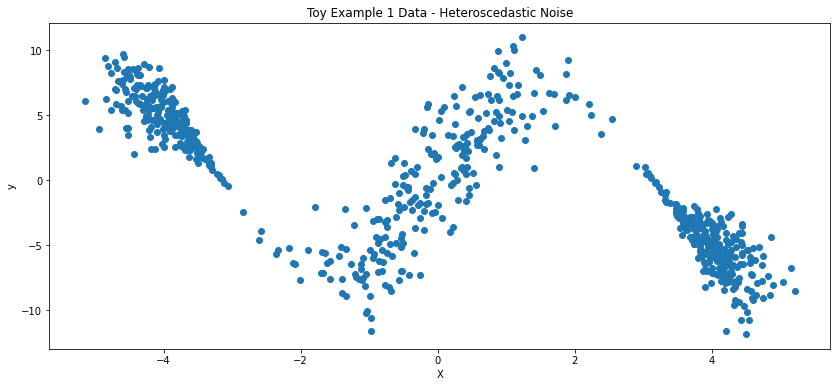

In [46]:
y_hsc, X_hsc = generate_regression_outputs(type='hsc')

X_test_hsc_100 = np.linspace(min(X_hsc), max(X_hsc), 100)
X_test_hsc_400 = np.linspace(min(X_hsc), max(X_hsc), 400)

plt.figure(figsize=(14,6))
plt.scatter(X_hsc, y_hsc)
plt.title("Toy Example 1 Data - Heteroscedastic Noise")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

#### Results



Below we present the results from replicating this heteroscedastic toy example using all of HMC, PYMC3 and BBVI in order to compared and constrast our results
to the original paper.


#### Sampling - HMC

HMC proved difficult to sample effectively given the size of the posterior and issues with storing and tracking the samples as we were running
the sampler. As such we have far fewer than the 200,000 samples that Depeweg et al. had for the official paper at just 6000 prior to burn in and and thinning.

In [ ]:
# see `heteroscedastic/training_hsc_hmc.ipynb` for sampling code
posterior_samples_hmc_hsc = np.load('heteroscedastic/saved_samples/hsc_samples_hmc.npy')

In [ ]:
# NOTE - 6000 samples total, 1000 samples to burn in, thinning factor of 2

# Drop the 750 samples from Z as they aren't required for predictions (just keep the weights)
posterior_samples_hmc_hsc = posterior_samples_hmc_hsc[-5000:, 0:bnn_lv.D]

# Thin by a factor of 2 - leaving 2500 samples
posterior_samples_hmc_hsc = posterior_samples_hmc_hsc[::2,:]

# Reshape so that samples are (SxMxD)
posterior_samples_hmc_hsc = posterior_samples_hmc_hsc.reshape(posterior_samples_hmc_hsc.shape[0], 1, posterior_samples_hmc_hsc.shape[-1])

# Check shape
posterior_samples_hmc_hsc.shape

(2500, 1, 501)

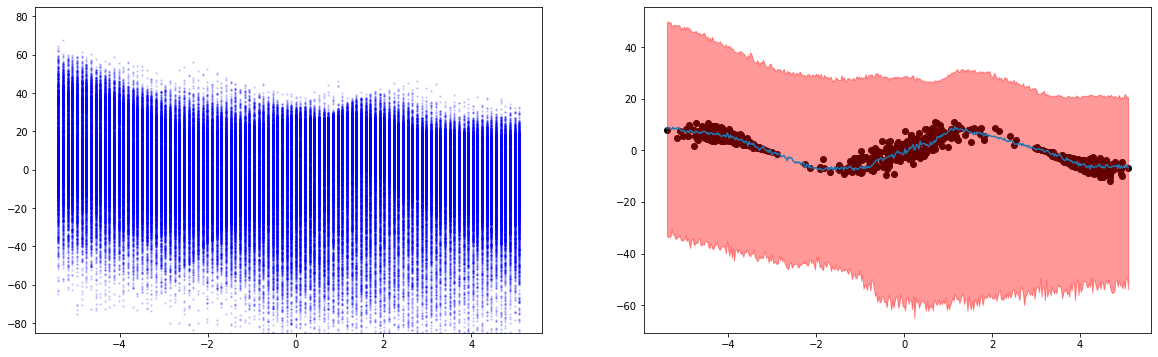

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_posterior_predictive(X_test_hsc_100, bnn_lv, posterior_samples_hmc_hsc, mode='points', ax=ax[0], figsize=(14,7), real_x=X_hsc, real_y=y_hsc)
plot_posterior_predictive(X_test_hsc_400, bnn_lv, posterior_samples_hmc_hsc, mode='fill', ax=ax[1], figsize=(14,7), real_x=X_hsc, real_y=y_hsc)
ax[0].set_ylim(-85,85)
plt.show()

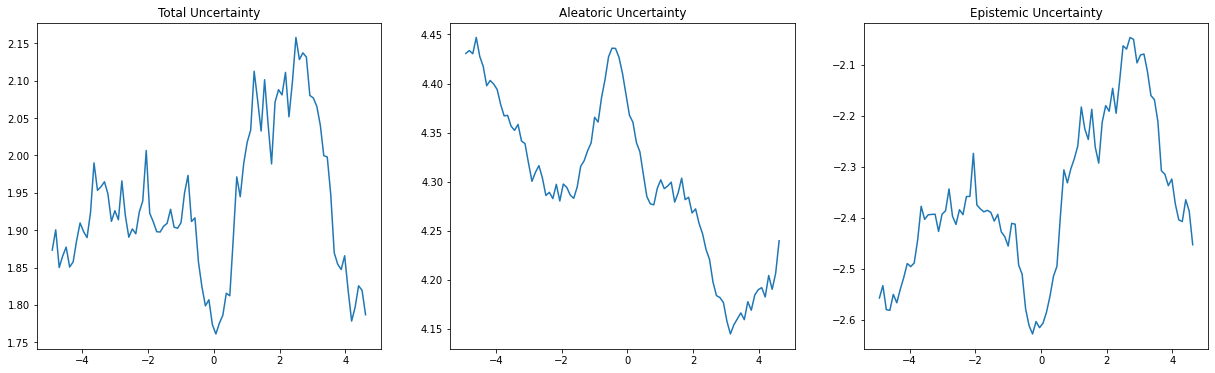

In [ ]:
epistemic_entropy_hmc_hsc, aleatoric_entropy_hmc_hsc =  uncertainty_decompose_entropy(bnn_lv, X_hsc, posterior_samples_hmc_hsc,
                                                                                            S=250, N=250, N2=100, D=1, avg_window=10)

Immediately we see that the posterior predictive for the HMC sampled heteroscedastic noise case has a far higher variance than the equavalent in the original
paper. The points plot, showing a random sample of points from the final 2,500 sampled weights are almost a solid block and barely highlight the specific shape of the
underlying data. This is due to a very high level of aleatoric uncertainty across all the data points, which results in such large 95% confidence intervals (as seen
in the right hand of the two charts).

What is very interesting though, is that even though we did not converge well to the posterior of the BNN+LV and are certaintly not well representing the underlying
data function, the breakdown of aleatoric and epistemic uncertainty is, at least in some ways, similar to the one achieved in the original paper. It has clearly
highlighted that there is a higher peak of aleatoric uncertainty around zero, where we know the data has a higher inherent variation and also the epistemic 
uncertainty is in two distinct peaks which correspond to the areas of missing data. So while the overall replication is poor, there is at least the hint of it
being able to correctly decompose the noise into aleatoric and epistemic components.

---

#### Sampling - PYMC3

We followed HMC by attempting the same toy problem using pymc3. After adjusting some of the NUTS parameters to allow for larger maximum trees and more stringent target acceptance rates, we arrived at a promising setup for sampling.

In [ ]:
# see `heteroscedastic/training_hsc_pymc3.ipynb` for sampling code
posterior_samples_pymc3_hsc = np.load('heteroscedastic/saved_samples/hsc_samples_pymc3.npy')

In [ ]:
#burning and thinning
posterior_samples_pymc3_hsc = posterior_samples_pymc3_hsc[200:][::2]

In [ ]:
posterior_samples_pymc3_hsc.shape

(2900, 1, 501)

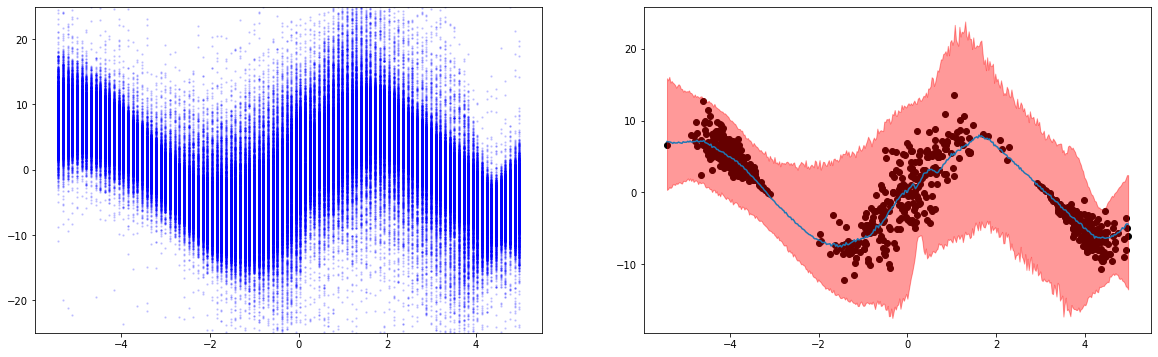

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_posterior_predictive(X_test_hsc_100, bnn_lv, posterior_samples_pymc3_hsc, mode='points', ax=ax[0], figsize=(14,7), real_x=X_hsc, real_y=y_hsc)
plot_posterior_predictive(X_test_hsc_400, bnn_lv, posterior_samples_pymc3_hsc, mode='fill', ax=ax[1], figsize=(14,7), real_x=X_hsc, real_y=y_hsc)
ax[0].set_ylim(-25,25)
plt.show()

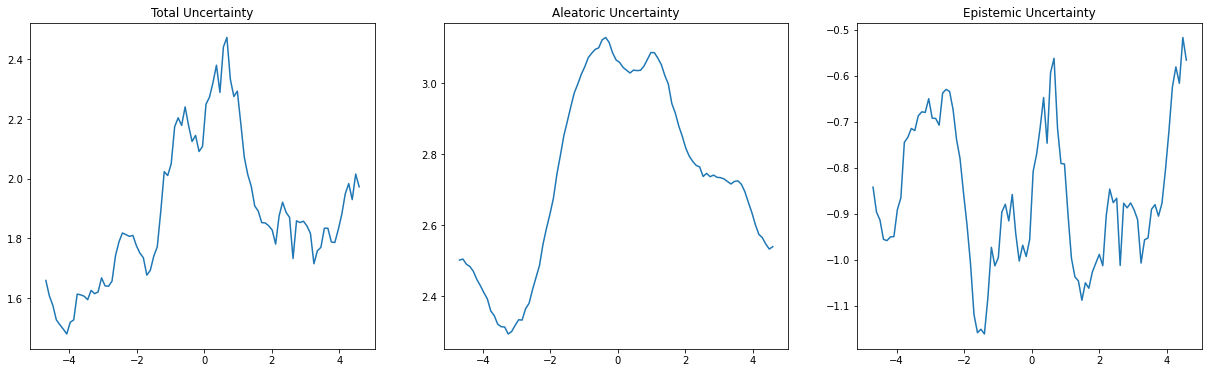

In [ ]:
epistemic_entropy_pymc3_hsc, aleatoric_entropy_pymc3_hsc =  uncertainty_decompose_entropy(bnn_lv,X_hsc, posterior_samples_pymc3_hsc,
                                                                                            S=650, N=650, N2=100, D=1, avg_window=10)

As we can see from the posterior predictive above, the posterior samples from our pymc3 implementation were able to meet our expectations in capturing widened preditive intervals in data sparse regions.

Furthermore, after utilizing the entropy-based approach to decompose uncertainty into aleatoric and epistemic, we were able to find some parallels to results found in the paper. We see that the epistemic uncertainty is inversely proportional to the data density - reaching minima as the density of training data was maximum. We also see aleatoric uncertainty coming to a maximum around 0 - matching with the central data region where points are less dense and have inherent noise. 

For the goal of active learning, the most important points in this toy data are in regions of highest scarcity. This aligns somewhat with our epistemic uncertainty plot - where the most informative $x$ should be where epistemic uncertainty is maximized - we see peaks spot on at around -3 and another smaller peak around 2.5 - matching with the low density data regions.

---

#### Sampling - BBVI

In [47]:
# see `heteroscedastic/training_hsc_bbvi.ipynb` for sampling code
posterior_samples_bbvi_hsc = np.load('heteroscedastic/saved_samples/hsc_samples_bbvi_65fgxpup.npy')

In [48]:
# Drop the 750 samples from Z as they aren't required for predictions (just keep the weights)
posterior_samples_bbvi_hsc = posterior_samples_bbvi_hsc[-5000:, 0:bnn_lv.D]

# Reshape so that samples are (SxMxD)
posterior_samples_bbvi_hsc = posterior_samples_bbvi_hsc.reshape(posterior_samples_bbvi_hsc.shape[0], 1, posterior_samples_bbvi_hsc.shape[-1])

# Check shape
posterior_samples_bbvi_hsc.shape

(5000, 1, 501)

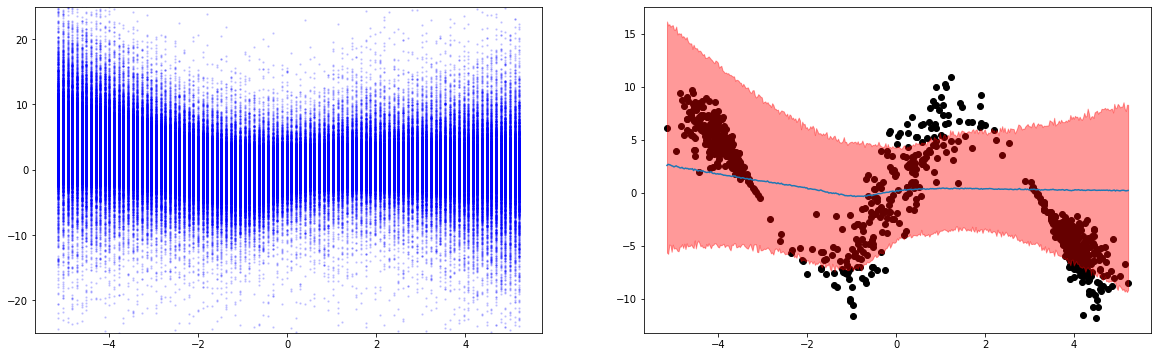

In [49]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_posterior_predictive(X_test_hsc_100, bnn_lv, posterior_samples_bbvi_hsc, mode='points', ax=ax[0], figsize=(14,7), real_x=X_hsc, real_y=y_hsc)
plot_posterior_predictive(X_test_hsc_400, bnn_lv, posterior_samples_bbvi_hsc, mode='fill', ax=ax[1], figsize=(14,7), real_x=X_hsc, real_y=y_hsc)
ax[0].set_ylim(-25,25)
plt.show()

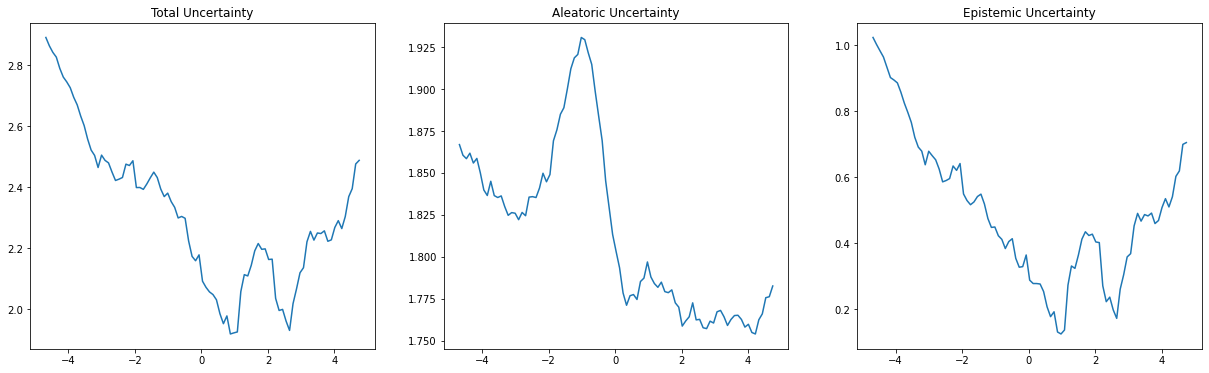

In [50]:
epistemic_entropy_bbvi_hsc, aleatoric_entropy_bbvi_hsc =  uncertainty_decompose_entropy(bnn_lv,X_hsc, posterior_samples_bbvi_hsc,
                                                                                            S=400, N=400, N2=100, D=1, avg_window=10)

We can see from the above posterior predictive, that the BBVI method struggled to accurately fit the data and generate reasonable predictive intervals. Interestingly, the 50% line isn't able to capture the curvature of the data, and we have widened intervals along the left and right sides. Though we had 5000 estimates from bbvi though they were in the right region, and weren't as widely dispersed as hmc's they failed to capture the data very well.

BBVI faced similar difficulty in uncertainty decomposition. BBVI was unable to generate robust samples to produce expected plots for epistemic uncertainty. We would have expected to see epistemic uncertainty oscillating with peaks around -2, 2 and valleys at -3, 0, 3. Though the epistemic uncertainty reached an expected low point near 0, and increased up to a peak at 2, beyond x=3 and x=-3, the epistemic uncertainty continued to increase even through the region of highest data density. Similarly, we expected to see a singular peak aleatoric uncertainty around x=0. Our aleatoric decomposition is able to match that decently with a peak around -1, however, the aleatoric unceratinty stays surprisingly high at x<-2.

---
---

### Bimodal Noise

Bimodal data is another interesting example as it acts to test the ability of the BNN+LV to represent unknown latent variables. Specifically here
there is a single unknown latent variable which effectively splits the data out into two distinct categories. The equation is set up so that one mode
is presented by a sine wave and the other a cosine wave, in doing so there is an area where both modes are distinct from one another and an area where they
cross and become indistinguishable (due to the phase difference). The formula for $y$ is:

$$
y = z(10cos(x) + \epsilon) + (1-z)(10sin(x) + \epsilon) \qquad \text{where} \quad \epsilon \sim N(0,1)
$$

To create the additional testing for epistemic uncertainty the $X$ values are drawn from an exponential distribution which is more densely clustered around 
zero.

$$
X \sim Exponential(0.5) \qquad Z \sim Bernoulli(0.5)
$$


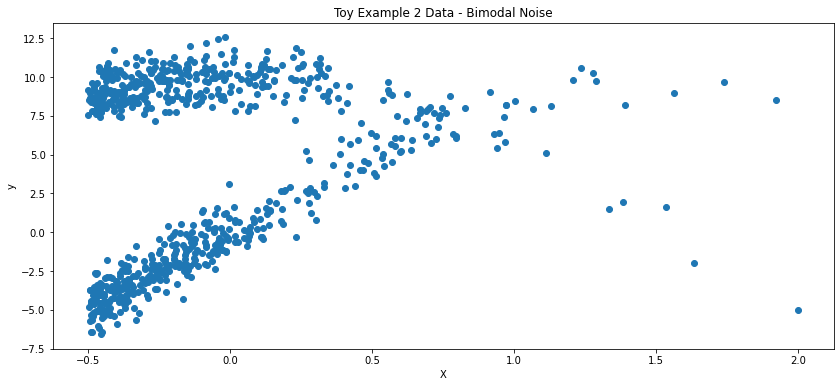

In [21]:
y_bimodal, X_bimodal = generate_regression_outputs(type='bimodal')

X_test_bimodal_100 = np.linspace(min(X_bimodal), max(X_bimodal), 100)
X_test_bimodal_400 = np.linspace(min(X_bimodal), max(X_bimodal), 400)

plt.figure(figsize=(14,6))
plt.scatter(X_bimodal, y_bimodal)
plt.title("Toy Example 2 Data - Bimodal Noise")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

#### Results

Below we present the results from replicating this bimodal toy example using all of HMC, PYMC3 and BBVI in order to compared and constrast our results
to the original paper.


#### Sampling - HMC

Similarly for the heteroscedastic noise case, we struggled to gather sufficient samples to get a full idea of how well HMC might replicate the experiments run
in the original paper. Here we achieved 6,200 samples prior to burn in and thinning.

In [ ]:
# see `bimodal/training_bimodal_hmc.ipynb` for sampling code
posterior_samples_hmc_bimodal = np.load('bimodal/saved_samples/bimodal_samples_hmc.npy')

In [ ]:
# NOTE - 6200 samples, 1200 samples to burn, thinning of 8

# Drop the 750 samples from Z as they aren't required for predictions (just keep the weights)
posterior_samples_hmc_bimodal = posterior_samples_hmc_bimodal[-5000:posterior_samples_hmc_bimodal.shape[0], 0:bnn_lv.D]

# Reshape so that samples are (SxMxD)
posterior_samples_hmc_bimodal = posterior_samples_hmc_bimodal.reshape(posterior_samples_hmc_bimodal.shape[0], 1, posterior_samples_hmc_bimodal.shape[-1])


posterior_samples_hmc_bimodal = posterior_samples_hmc_bimodal[::8]

# Check shape
posterior_samples_hmc_bimodal.shape

(625, 1, 501)

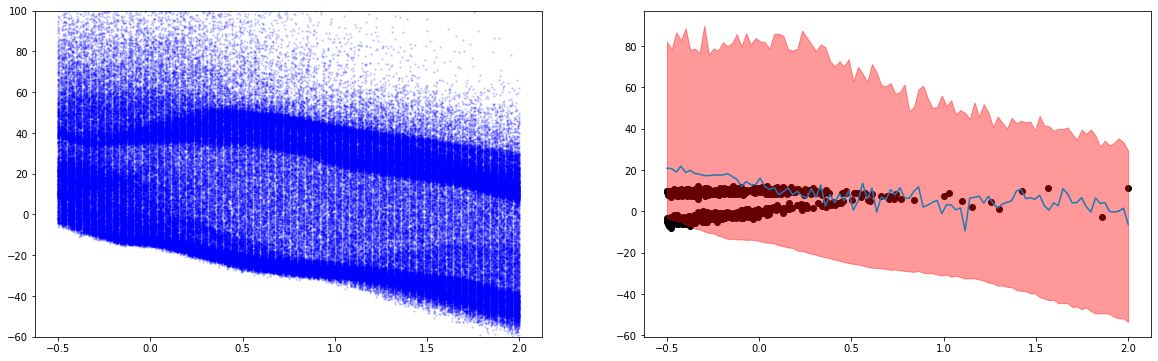

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_posterior_predictive(X_test_bimodal_400, bnn_lv, posterior_samples_hmc_bimodal, mode='points', ax=ax[0], figsize=(14,7), real_x=X_bimodal, real_y=y_bimodal)
plot_posterior_predictive(X_test_bimodal_100, bnn_lv, posterior_samples_hmc_bimodal, mode='fill', ax=ax[1], figsize=(14,7), real_x=X_bimodal, real_y=y_bimodal)
ax[0].set_ylim(-60,100)
plt.show()

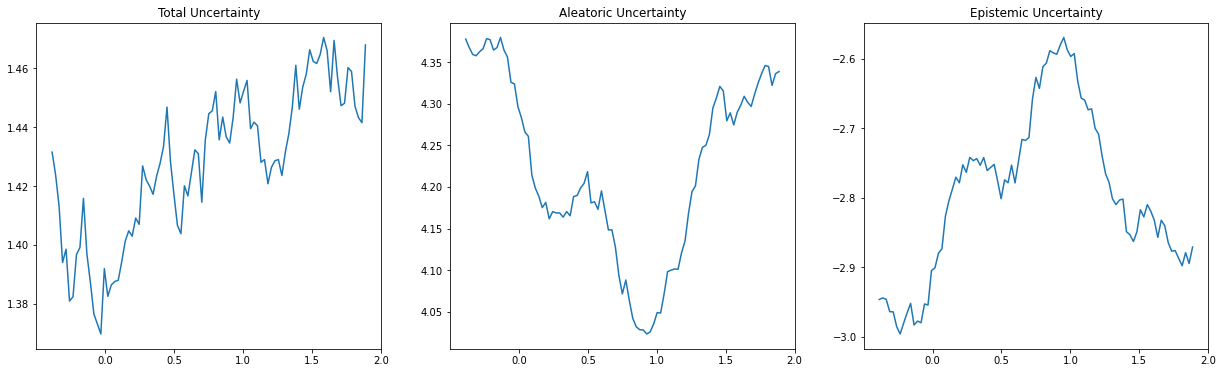

In [ ]:
epistemic_entropy_hmc_bimodal, aleatoric_entropy_hmc_bimodal = uncertainty_decompose_entropy(bnn_lv,X_bimodal, posterior_samples_hmc_bimodal,
                                                                                            S=500, N=500, N2=100, D=1, avg_window=10)

The results for our HMC sampling are again hindered by the low overall sample count and therefore the very small amount of burn in that we are able to 
perform whilst still retaining sufficient levels of samples. The overall uncertainty in this toy example should mirror the curve shown by the aleatoric uncertainty,
it should be a slight bowl around 0.75 and taper up towards the edges. As we can clearly see it appears to be highly variant across the x-data range. Another 
clear issue here is that we know, from the problem configuration, that epistemic uncertainty should increase as X increases due to the exponential sampling distribution
whereas here we see a strong peak in epistemic uncertainty before a drop.

Due to the poor overall quality of the samples it is difficult to draw any overall parallels between this toy example and the one performed in the paper.

---

#### Sampling - PYMC3

Similarly to the heteroscedastic case, we followed HMC sampling by attempting the same toy problem using pymc3. Pymc3 had a slighly harder time with this method, and we werent able to sample as many values. However, after adjusting the NUTS parameters we obtained the results below. Even though we werent able to obtain as many samples, due to the efficiencies of pymc3 we were able to get successful results from this sampling method that aligned well with the results in the paper.

In [ ]:
#see `bimodal/training_bimodal_pymc3.ipynb` for sampling code
posterior_samples_pymc3_bimodal = np.load('bimodal/saved_samples/bimodal_samples_pymc3.npy')

In [ ]:
posterior_samples_pymc3_bimodal.shape

(600, 1, 501)

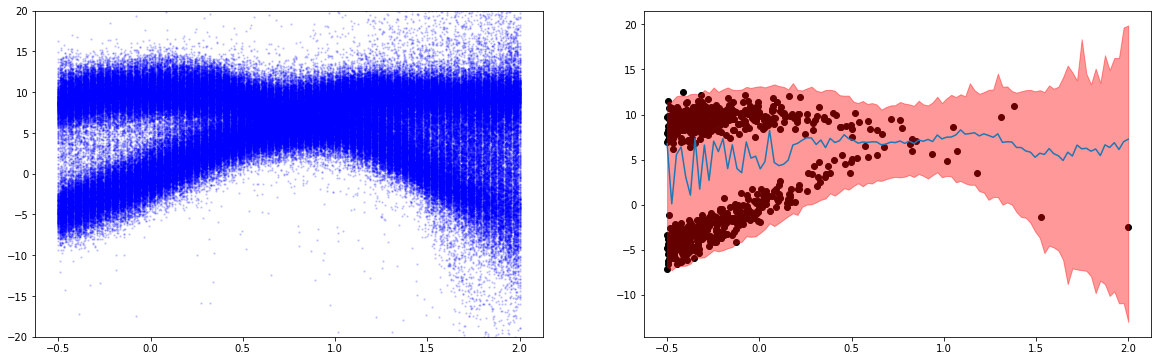

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_posterior_predictive(X_test_bimodal_400, bnn_lv, posterior_samples_pymc3_bimodal, mode='points', ax=ax[0], figsize=(14,7), real_x=X_bimodal, real_y=y_bimodal)
plot_posterior_predictive(X_test_bimodal_100, bnn_lv, posterior_samples_pymc3_bimodal, mode='fill', ax=ax[1], figsize=(14,7), real_x=X_bimodal, real_y=y_bimodal)
ax[0].set_ylim(-20,20)
plt.show()

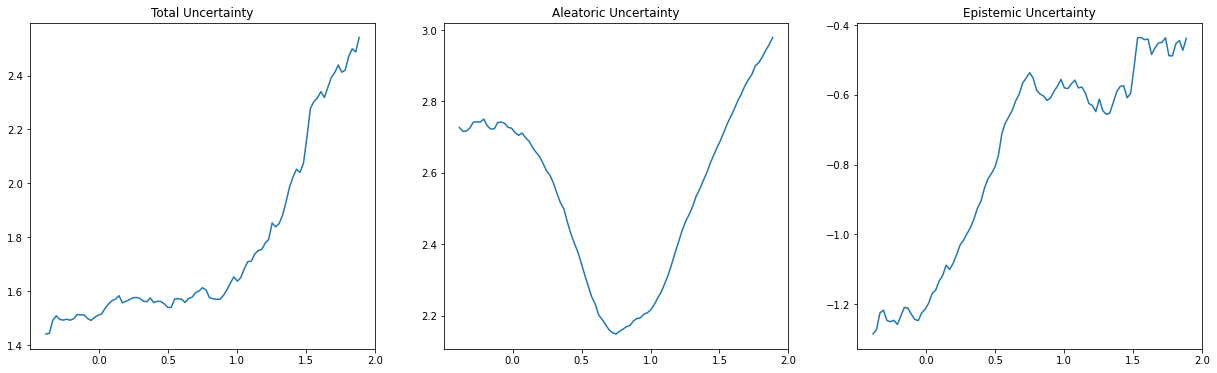

In [ ]:
epistemic_entropy_pymc3_bimodal, aleatoric_entropy_pymc3_bimodal = uncertainty_decompose_entropy(bnn_lv,X_bimodal, posterior_samples_pymc3_bimodal,
                                                                                            S=650, N=650, N2=100, D=1, avg_window=10)

The samples we obtained from pymc3 produced posterior predictive distributions that aligned with our expectations. Since we had a high density of points on the left, and much fewer for larger values of x, we expected to see an increased incertainty in this region. This is apparent from our posterior predictive - with the 95% PI emcompassing both the high density modes on the left and then widening out on the right where there was no training data.

Our uncertainty decomposition tells a similar story - we can see that the both the total uncertainty and epistemic uncertainty have clear relationships of increasing with x as the sparsity of data increases on the right side. Like in the paper, we also observe our aleatoric uncertainty to be almost symmetric around $x=0.75$, which can be explained by the fact that this is the point in the data where the noise changes from being bimodal to being unimodal - the data generating process is symmetric about this point. 

---

#### Sampling - BBVI

In [23]:
# see `heteroscedastic/training_bimodal_bbvi.ipynb` for sampling code
posterior_samples_bbvi_bimodal = np.load('bimodal/saved_samples/bimodal_samples_bbvi_2s0pdpfz.npy')

In [24]:
# Drop the 750 samples from Z as they aren't required for predictions (just keep the weights)
posterior_samples_bbvi_bimodal = posterior_samples_bbvi_bimodal[-5000:, 0:bnn_lv.D]


# Reshape so that samples are (SxMxD)
posterior_samples_bbvi_bimodal = posterior_samples_bbvi_bimodal.reshape(posterior_samples_bbvi_bimodal.shape[0], 1, posterior_samples_bbvi_bimodal.shape[-1])

# Check shape
posterior_samples_bbvi_bimodal.shape

(5000, 1, 501)

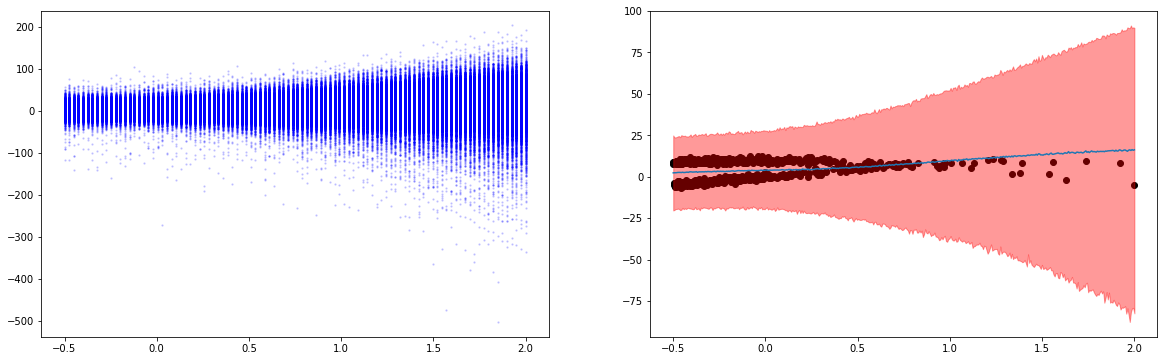

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
plot_posterior_predictive(X_test_bimodal_100, bnn_lv, posterior_samples_bbvi_bimodal, mode='points', ax=ax[0], figsize=(14,7), real_x=X_bimodal, real_y=y_bimodal)
plot_posterior_predictive(X_test_bimodal_400, bnn_lv, posterior_samples_bbvi_bimodal, mode='fill', ax=ax[1], figsize=(14,7), real_x=X_bimodal, real_y=y_bimodal)
plt.show()

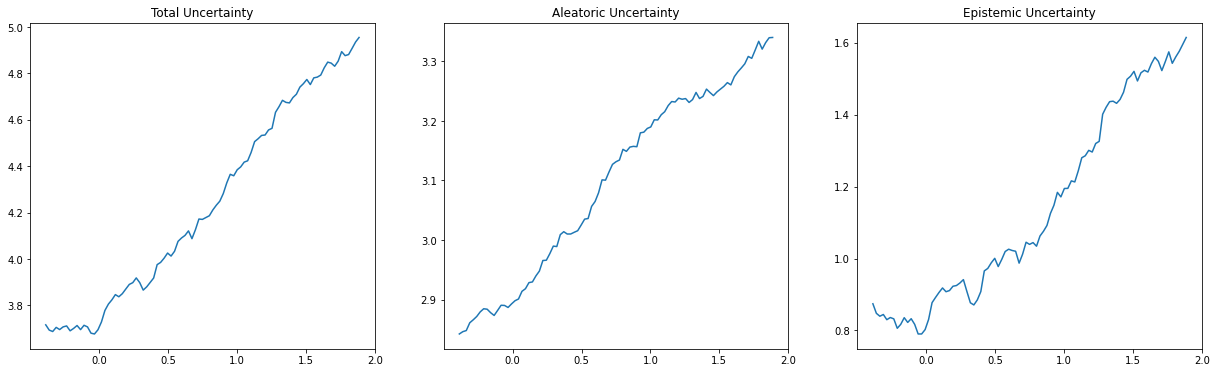

In [29]:
epistemic_entropy_bbvi_bimodal, aleatoric_entropy_bbvi_bimodal =  uncertainty_decompose_entropy(bnn_lv,X_bimodal, posterior_samples_bbvi_bimodal,
                                                                                                S=400, N=400, N2=100, D=1, avg_window=10)

BBVI has been almost totally unable to split the aleatoric from epistemic uncertainty in this example, both showing an identical trend to the overall uncertainty
which is simply increasing as X increases. It has not been able to capture the decrease in uncertainty that occurs around x=0.75 where the noise becomes unimodal. This BBVI posterior predictive confidence interval shows that the approximation from which we are sampling weights, is likely still not very
close to the true distribution of the posteior.

---
---

### Reinforcement Learning Wet Chicken



In reinforcement learning, an agent uses feedback from its environment (i.e. costs and rewards) to improve its policy.
As it takes actions explores the various states of the environment, it learns the policy (i.e. the function it uses to 
decide which action to take in each state) that will help it maximize its expected rewards. 
Given the potentially enourmous number of state--action pairs and the fact that, because of stochasticity in 
the environment, the same state--action pair may lead to different rewards, it can take considerable time for the agent 
to develop a reliable internal model of how to maximize its rewards. Once it has found states and actions that give 
high payoffs, it may tend to use them to accrue rewards rather than exploring further for potentially better results.

This illustrates one of the central challences of RL: balancing exploration and exploitation.
The decomposition proposed by Depeweg et al. lends itself well to this problem, since it can
help evaluate where the agent still needs to explore, and whether its previous experiences 
are the result of a consistent pattern or simply of random chance. This is helpful for 
understanding whether returning to a previous state is likely to have the same as on the previous visit.

In our experiments, we will focus on the first phase of Model-based RL, where the goal is to use data collected
from the system to learn a transition function that, given a current state and action taken by the agent, 
predicts what the next state will be. To do this, we use a toy RL problem called the "Wet Chicken", in which 
a person in a canoe tries to get as close as possible to a waterfall without being drawn over the edge. 
The original Wet Chicken problem (in 1 dimension) is attributed to Volker Tresp in a 1994 Technical Report; 
a 2D version (in continuous space) is stated in \[15\].


#### Set up Wet Chicken system

This implementation is a simplified 2D version of the problem in discrete space. 
- The river is represented as a 3x5 grid, which and has both current (deterministic) and turbulence (stochastic),
which vary along the width of the river.
- The left bank of the river (x=1) has high turbulence but no current.
- The right bank of the river (x=3) has current that moves fast towards the waterfall but no turbulence.
- The waterfall is located at y=0.
- The canoeist beings each episode upstream of the water, at y=5, with an x postion (1, 2, or 3) chosen at random.
- The canoeist chooses between four actions: paddle backards, paddle left, paddle right, or don't paddle.


In [6]:
from utils.models import BNN, BNN_LV
import autograd.numpy as np

In [34]:
from utils.games import WetChicken2D
from utils.decomposition import chicken_entropy_decompose

env = WetChicken2D(L=5, W=3, max_steps=20, seed=207)
no_action_policy = lambda state: (0,0)  # For any state, play the "do nothing" action.
env.run(episodes=100, progress=None, policy=no_action_policy)

Below, we set up our transitions dataset - with starting x,y action x,y (which in the example for this notebook will always be 0), and the result x,y

In [8]:
transitions = env.extract_transition_dataset()
transitions = transitions.sample(frac=1, replace=False, random_state=123)
transitions.head()

,start_x,start_y,action_x,action_y,result_x,result_y
344,1,5,0,0,1,5
482,3,4,0,0,3,0
78,3,4,0,0,3,1
185,1,5,0,0,1,5
261,1,5,0,0,1,5


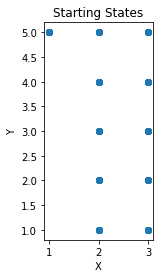

In [32]:
plt.scatter(transitions['start_x'],transitions['start_y'])
plt.title('Starting States')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

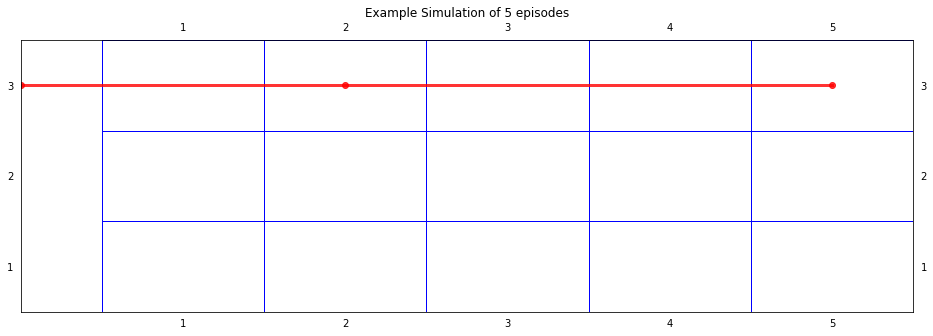

In [36]:
env.plot_episode(ep=5)
plt.title('Example Simulation of 5 episodes')
plt.show()

In [9]:
# Build training data 
X_train_chicken = transitions[['start_x','start_y','action_x','action_y']].to_numpy()
Y_train_chicken = transitions[['result_x','result_y']].to_numpy()

print('X :',X_train_chicken.shape)
print('Y :',Y_train_chicken.shape)

X : (845, 4)
Y : (845, 2)


### Set up BNN_LV for Wet Chicken problem

In [12]:
# Parameters
gamma_chicken = 1
sigma_chicken = 1

architecture_chicken = {'input_n':4, 
             'output_n':2, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma_chicken],
             'sigma':[sigma_chicken,sigma_chicken]}

bnn_lv_chicken = BNN_LV(architecture=architecture_chicken)

### Sampling - HMC

Due to the added complexity of the Wet Chicken problem - we ran into memory issues at fewer samples and therefore have just 5,200 prior to burn in and thinning.

In [16]:
posterior_samples_hmc_chicken = np.load('chicken/saved_samples/chicken_samples_hmc.npy')

In [26]:
# Drop the Z samples and leave just the weights
posterior_samples_hmc_chicken = posterior_samples_hmc_chicken[:,0:bnn_lv_chicken.D]

# Burn in the first 1200 samples
posterior_samples_hmc_chicken = posterior_samples_hmc_chicken[-4000:, :]

# Thin by a factor of 2
posterior_samples_hmc_chicken = posterior_samples_hmc_chicken[::2, :]

# Reshape to correct dimensions
posterior_samples_hmc_chicken = posterior_samples_hmc_chicken.reshape(posterior_samples_hmc_chicken.shape[0], 1, posterior_samples_hmc_chicken.shape[-1])

# Check shape
posterior_samples_hmc_chicken.shape

(2000, 1, 582)

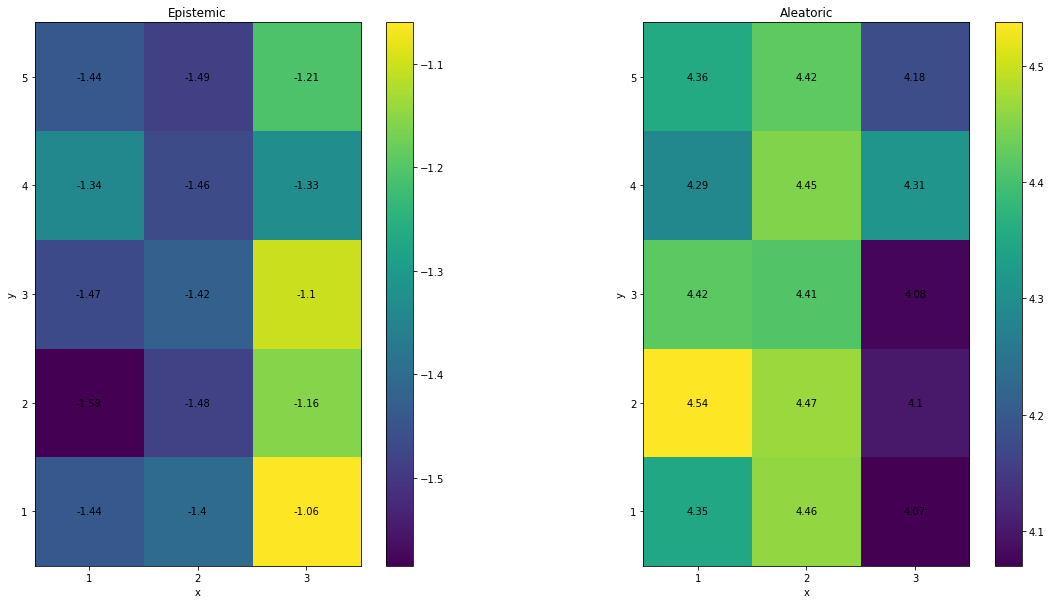

In [42]:
N = 90 # number of 15 pt repeats
N2 = 10 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

# Run the entropy decomposition for the 2D chicken
chicken_decomp_hmc = chicken_entropy_decompose(bnn_lv_chicken, transitions, posterior_samples_hmc_chicken, N, N2, L)

There are a number of issues with the estimates of aleatoric and epistemic uncertainty for the HMC samples. The problem is set up in such a way
that we should have very few samples where $x=1$ and $ y <= 4$ due to the canoeist not moving when being intialized at the top of the river. In this case there
appears to be relatively even, or even lower uncertainty in this bottom left corner which is contradictory to the problem set up.

For the aleatoric uncertainty, the problem is structured so that the right hand side of the river ($x=3$) is fully determinsitic and there is high randomness
at the left side of the river ($x=1$). The HMC samples do appear to have a lower aleatoric uncertainty where the river is deterministic but it is also relatively 
even and highest uncertainty appears to be around the middle. 

Again we suspect that due to the low number of total samples and small burn in period, these samples are not well approximating the true posterior and so it is
not surprising that the uncertainty decomposition is failing.

---

### Sampling - PYMC3

In [37]:
posterior_samples_pymc3_chicken = np.load('chicken/saved_samples/chicken_samples_pymc3.npy')

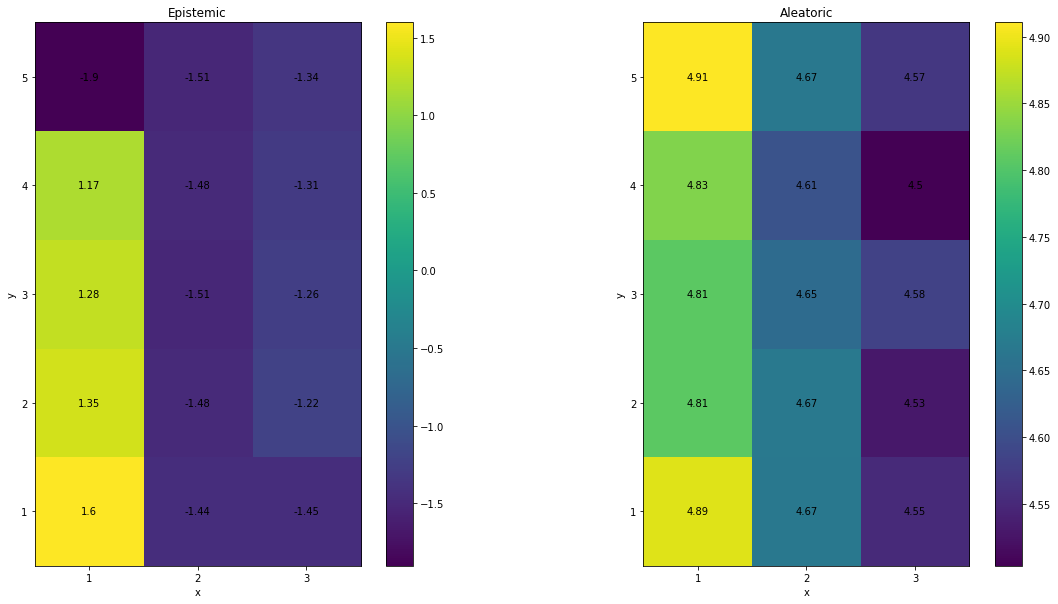

In [41]:
N = 90 # number of 15 pt repeats
N2 = 10 # number of 15 pt repeats for calculating entropy
L = 10 # Number of y points to take per set of samples for epistemic uncertainty

chicken_decomp_pycm3 = chicken_entropy_decompose(bnn_lv_chicken, transitions, posterior_samples_pymc3_chicken, N, N2, L)

The pymc3 implementation of wet chicken was able to capture more of the uncertainties that we expected to see. Since our simulation space did not include starting points for x=1 from y=1 to y=4, it makes sense that this is the region with highest epistemic uncertainty. This highlights that these are key areas of active learning - as these maximum epistemic uncertainties are the most informative x's for which to collect y's.  There is also notably lower aleatoric uncertainty along the right side x=3, which aligns well with the system dynamics - as this side has fully deterministic dynamics.

---
---

## Comparing Results

Summarise the previous section in terms of what we found
* What are our high level takeaways in terms of our results

Our PYMC3 implementation was able to obtain reasonable samples from the complex posterior of the latent variable BNN in all of our example cases. We believe that due to the efficiencies of the NUTS sampler, we were able to explore the space intelligently to obtain reasonable samples. 

From this NUTS implementation,the resulting uncertainty decompositions aligned closely with the results from the paper on toy bimodal and heteroscedastic datasets. It was also able to capture expected behaviors in our custom wet-chicken system. We were able to notice clear trends in uncertainty that aligned with our understanding of sparisity or density of the training data. Through the "broken-out" epistemic uncertainty, we would be able to identify informative inputs. 

However, our custom HMC implementation tended to struggle more. It is likely ta



* How close did we get to replicating?
* Does it work?

* Alpha choice is kinda arbitrary?

## Evaluation

Looking back at the results from our replication of the paper at a high level, we did manage to reproduce some of the claimed uncertainty decomposition properties
that the authors of the original paper were claiming to produce and so we do believe that there is evidence to believe that the BBN with Latent Variables can be used
effectively to split out aleatoric from epistemic uncertainty, under the specific and very limited examples presented in this paper.

One of our key take-aways from having reproduced this paper is the lack of fundamental mathematical theory...

Also the examples in this paper are too simple, being just single examples of heteroscedastic and bimodal noise in one dimension, along with a simplified reinforcement
learning problem, to truly assess whether this method is generalization to real world use cases where both the number of data points and dimensions is likely to be much, 
much higher. One of the most challenging differences between the BBN+LV and the standard BNN model in terms of fitting is that we also have to sample a Z (latent variable)
per row of our input data. Hence this approach scaled incredibly poorly with the size of the dataset and additional datapoints actually makes it much more difficult to 
sample from the posterior, whereas for a standard BNN this would depend only on the number of weights present.


Finally, and perhaps the most difficult thing is that even amongst our team, we cannot agree on which methods and which results appear to be the "best". This whole
approach of visually verifying the results based on plotting the uncertainties is incredibly subjective and no a principled approach. We dicussed in class at great 
length that visual checks can be misleading and so we turned to more numeric approaches a such as calculating likelihoods numerically. That sense of rigor appears
to be one of the largest problems with the apporach

More about critiquing their paper
* From our investigations where are the flaws?
* Do we believe their results?
* Where would this approach fail?


Notes:
* No mathematical arguments - its an empirical study, qualitatively we know its desirable to have larger areas where there is less data but there is no metric really
  we know its working when it looks good.
* BB-alpha tuning seems very arbitrary - they kinda just set alpha to 0.5 and are like seems to work
* Wei Wei paper on lack of identifiablilty - this is clearly an issue but why?




## Future Work and Improvements

Given additional time and resources we would first like to take many more HMC based samples of the posterior and implement a BB-$\alpha$ based sampling approach
to first finish replicating the results in the original paper more similarly. It is clear from our results that our HMC sampler and BBVI approximations methods have
not sampled the posterior of the BNN+LV in such a way that we can draw direct parallels to their paper to understand precisely where this approach may or may not suceed.
The issue with HMC is it's training complexity and run time requirements that we just couldn't emulating in the time period we had. BBVI on the other hand, using the reverse
method as we have, is known to only approximate a single mode of the posterior and so we were not expecting it to be able to produce an accurate picture of the posterior
as the BB-$\alpha$ method managed to do.

Aside from wanted to better reproduce the original work, we also wish to expand our explorations out into higher dimensions, the toy examples and the 2D Wet chicken are
both relatively simple cases and do not explore the potential limitations of this approach in higher dimensions. One point which is immediately obvious is that 
using the KNN approximation of Entropy is highly likely to begin failing in high dimensions, as discussed previously, due to the curse of dimensionality causing points
in high dimensional space to become evenly spread around the edges of the space.

We would also like to follow up with an investigation into the Yacoby, Pan and Doshi-Velez paper \[3\] where they explored unidentifability and proposed a new
constrained training method for BNN+LVs. Given that we had obvioius difficulties, especially using HMC and BBVI, in producing weight samples from the posterior
which gave reasonable posterior predictives, we would like to try implementing the new constrained sampling approach. Doing so would enable us to be investigate
whether the decompositions we are seeing in our replica paper are repeatable attributes of the BNN+LV or just artefacts of our under performing sampling or something
inherent in the PYMC3 NUTS implementation which consistently managed to produce more similar results.

## Broader Impact 
Because Bayesian neural networks with latent variables are so flexible, 
they can be used to model nearly any situation imaginable.  The ability 
to model unseen variables is incredibly powerful and we have shown that 
we can get better estimates for the posterior when we use these latent 
representations.  However, practitioners should be extremely careful 
when including latent variables as they will learn whatever is 
mathematically optimal without regard to what is ethical or legal.  If 
you imagine using a BNN+LV to determine credit-worthiness, it is easy 
to imagine that the model could end up discovering a latent variable 
that essentially amounted to  race, gender, or some other protected 
class. The estimates of our variance might end up being more accurate, 
however they could also lead us to discriminate against individuals in 
an unlawful manner. This could lead to discrimination that hurts 
individuals and exposes the model architect to legal liabilities.  As 
such, we recommend that practitioners aggressively game out what could 
be included in their model that would be inappropriate, and if they 
believe such variables are likely to be associated with the response of 
interest, they avoid using latent variable representations.


## References

\[1\] Depeweg et al (2018). Decomposition of Uncertainty in Bayesian Deep Learning for Efficient Risk-sensitive learning. arXiv:1710.07283v4. Available at: https://arxiv.org/pdf/1710.07283.pdf


\[2\] Depeweg et al (2017). Learning and Policy Search in Stochastic Dynamical Systems With Baysian Neural Networks. arXiv:1605.07127v3. Available at: https://arxiv.org/pdf/1605.07127.pdf

\[3\] Yacoby, Pan and Doshi-Velez (2019). Learning Deep Bayesian Latent Variable Regression Models that Generalize: When Non-identifiability is a Problem. arXiv:1911.00569. Available at: https://arxiv.org/pdf/1911.00569.pdf
  
\[4\] Depeweg et al (2017). Sensitivity Analysis for Predictive Uncertainty in Bayesian Neural Networks. arXiv:1712.03605v1. Available at: https://arxiv.org/pdf/1712.03605.pdf

\[5\] Blundell et al (2015). Weight Uncertainty in Neural Networks. arXiv:1505.05424v2. Available at: https://arxiv.org/pdf/1505.05424.pdf
  
\[6\] Kendall and Gal (2017). What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision? arXiv:1703.04977v2. Available at: https://arxiv.org/pdf/1703.04977.pdf
  
\[7\] Kozachenko and Leonenko (1987). Sample Estimate of the Entropy of a Random Vector. Probl. Peredachi Inf., 1987, Volume 23, Issue 2, Pages 9–16. Available at: http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=ppi&paperid=797&option_lang=eng

\[8\] Singh et al (2003). Nearest Neighbor Estimates of Entropy. American Journal of Mathematical and
Management Sciences. 23:3-4, 301-321. Available at: https://doi.org/10.1080/01966324.2003.10737616

\[9\] Robertson et al (2014). Quantifying Epistemic and Aleatoric Uncertainty in the Ampair 600 Wind Turbine. SAND2014-20179C. Available at: https://www.osti.gov/servlets/purl/1242753

\[10\] Gong et al (2013). Estimating epistemic and aleatory uncertainties during hydrologic modeling: An information theoretic approach. Water Resources Research, Volume 49, Issue 4, Pages 2253-2273. Available at: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20161

\[11\] Hernandez-Lobato et al. (2016). Black-Box α-Divergence Minimization. arXiv:1511.03243v3. Available at: https://arxiv.org/pdf/1511.03243.pdf

\[12\] Monnahan, Thorson and Branch (2017). Faster estimation of Bayesian models in ecology usingHamiltonian Monte Carlo. Methods in Ecology and Evolution 2017, 8, 339–348. Available at: https://besjournals.onlinelibrary.wiley.com/doi/epdf/10.1111/2041-210X.12681

\[13\] Hoffman and Gelman (2011). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. arXiv:1111.4246v1. Available at: https://arxiv.org/pdf/1111.4246.pdf

\[14\] Xu et al. (2019). Stay Ahead of Poachers: Illegal Wildlife Poaching Prediction and Patrol Planning Under Uncertainty with Field Test Evaluations. arXiv:1903.06669v3. Available at: https://arxiv.org/pdf/1903.06669.pdf

\[15\] Hans & Udluf (2009. Efficient Uncertainty Propagation for Reinforcement Learning with Limited Data. Proc. Int. Conf. on Artificial Neural Networks (ICANN 2009), Cyprus, Part I, LNCS 5768, pp. 70-79. Available at: https://www.tu-ilmenau.de/fileadmin/media/neurob/publications/conferences_int/2009/Hans-ICANN-2009.pdf 